# Customer Segmentation and Clustering

## Import Libraries

In [19]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

import warnings

warnings.filterwarnings("ignore")

In [20]:
# Load Data
customers = pd.read_csv("Customers.csv")
transactions = pd.read_csv("Transactions.csv")

## Data Preparation

In [21]:
# Aggregate transaction data for each customer
agg_transactions = (
    transactions.groupby("CustomerID")
    .agg(
        TotalSpend=("TotalValue", "sum"),
        TotalTransactions=("TransactionID", "count"),
        AvgTransactionValue=("TotalValue", "mean"),
    )
    .reset_index()
)

In [22]:
# Merge with customer data
data = pd.merge(customers, agg_transactions, on="CustomerID", how="inner")

## Feature Engineering

In [23]:
# Convert SignupDate to a numerical feature (days since signup)
data["SignupDate"] = pd.to_datetime(data["SignupDate"])
data["DaysSinceSignup"] = (pd.Timestamp.now() - data["SignupDate"]).dt.days

In [24]:
# Select features for clustering
features = data[
    ["TotalSpend", "TotalTransactions", "AvgTransactionValue", "DaysSinceSignup"]
]

In [25]:
# Normalize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

## Clustering and Evaluation

In [ ]:
db_scores = []
for k in range(2, 11):  # Clusters between 2 and 10
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(scaled_features)
    db_index = davies_bouldin_score(scaled_features, labels)
    db_scores.append(db_index)

In [27]:
# Optimal number of clusters
optimal_k = 2 + np.argmin(db_scores)

In [28]:
# Final KMeans with optimal clusters
final_kmeans = KMeans(n_clusters=optimal_k, random_state=42)
final_labels = final_kmeans.fit_predict(scaled_features)
data["Cluster"] = final_labels

## Visualization

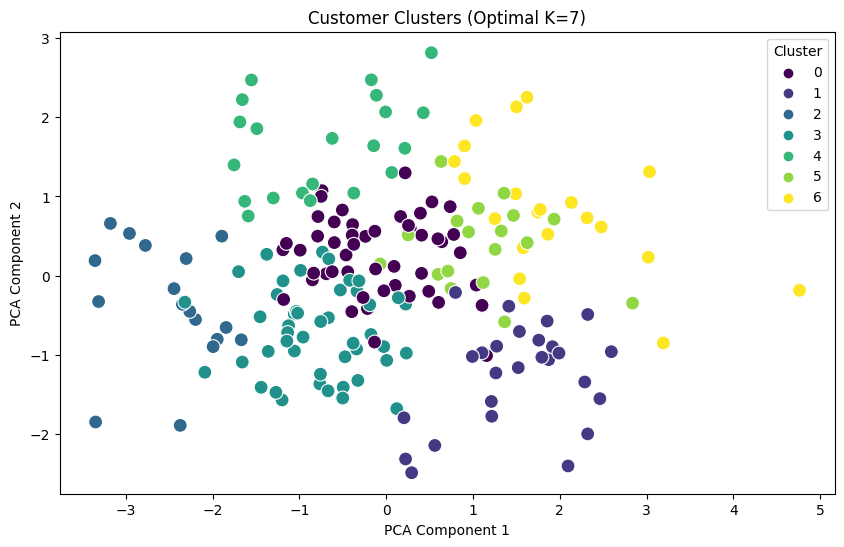

In [ ]:
# Reduce dimensions for visualization
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)
data["PCA1"] = pca_features[:, 0]
data["PCA2"] = pca_features[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(x="PCA1", y="PCA2", hue="Cluster", data=data, palette="viridis", s=100)
plt.title(f"Customer Clusters (Optimal K={optimal_k})")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.show()

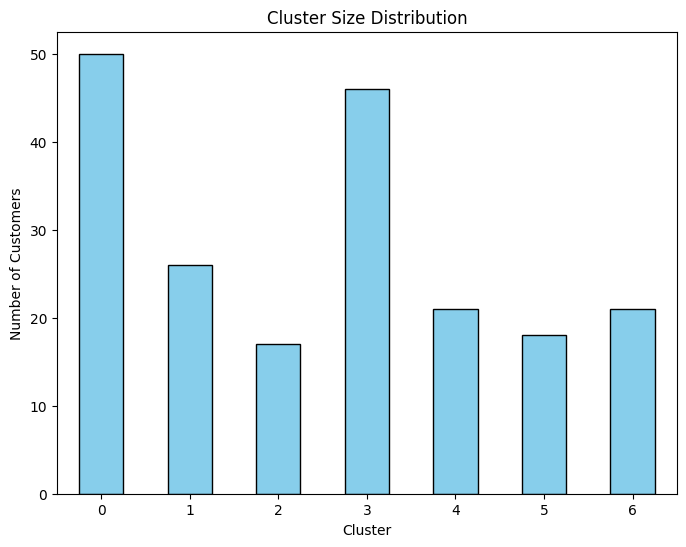

In [ ]:
# Cluster Size Distribution
plt.figure(figsize=(8, 6))
data["Cluster"].value_counts().sort_index().plot(
    kind="bar", color="skyblue", edgecolor="black"
)
plt.title("Cluster Size Distribution")
plt.xlabel("Cluster")
plt.ylabel("Number of Customers")
plt.xticks(rotation=0)
plt.show()

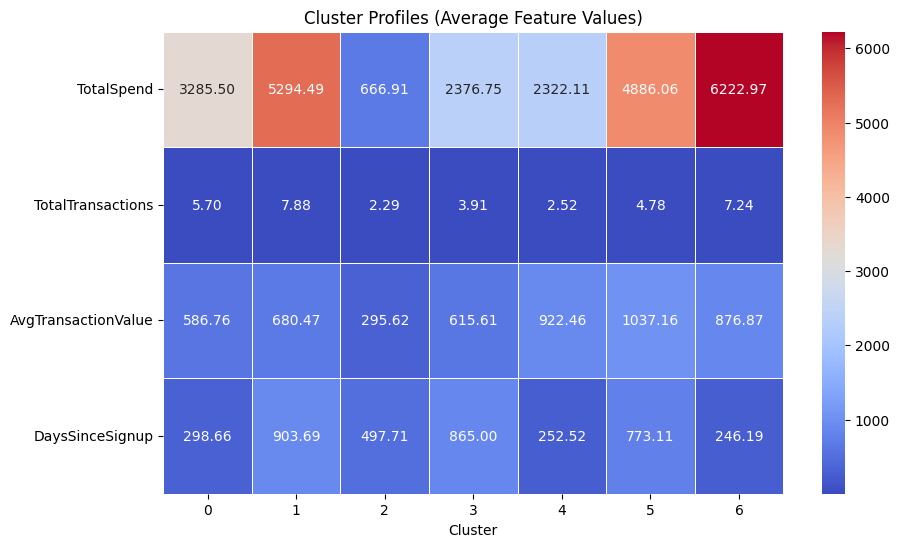

In [ ]:
# Cluster Profiles - Heatmap
cluster_profiles = data.groupby("Cluster")[
    ["TotalSpend", "TotalTransactions", "AvgTransactionValue", "DaysSinceSignup"]
].mean()
plt.figure(figsize=(10, 6))
sns.heatmap(cluster_profiles.T, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Cluster Profiles (Average Feature Values)")
plt.show()

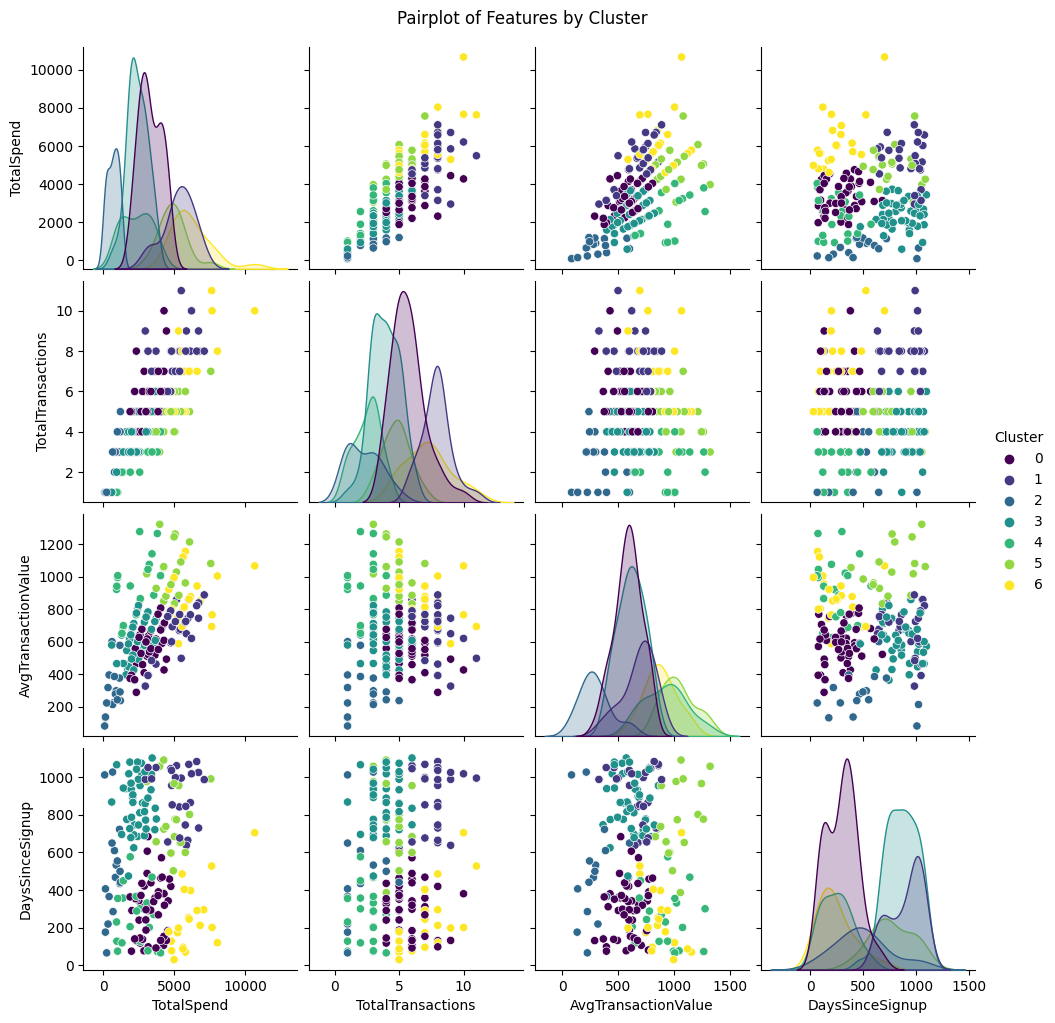

In [30]:
# Pairplot
sns.pairplot(
    data,
    vars=["TotalSpend", "TotalTransactions", "AvgTransactionValue", "DaysSinceSignup"],
    hue="Cluster",
    palette="viridis",
)
plt.suptitle("Pairplot of Features by Cluster", y=1.02)
plt.show()


## Results

In [34]:
print(f"Optimal Number of Clusters: {optimal_k}")
print(f"DB Index for Optimal Clusters: {db_scores[optimal_k - 2]:.2f}")

Optimal Number of Clusters: 7
DB Index for Optimal Clusters: 0.95
